# 11-2_LEARN-DataAnalysisML

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/11_LEARN_DataAnalysisML2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
import pandas as pd

In [3]:
# cloning the data repo
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


## 1. Setup H2O AutoML

In [4]:
import h2o
from h2o.automl import H2OAutoML

In [5]:
# If this doesnt work - install java. 
# Start the H2O cluster (locally)
h2o.init(ip="localhost", port=54323)

Checking whether there is an H2O instance running at http://localhost:54323 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_351"; Java(TM) SE Runtime Environment (build 1.8.0_351-b10); Java HotSpot(TM) 64-Bit Server VM (build 25.351-b10, mixed mode)
  Starting server from /Users/lucaslevassor/opt/anaconda3/envs/constrain/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmp1whxljou
  JVM stdout: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmp1whxljou/h2o_lucaslevassor_started_from_python.out
  JVM stderr: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmp1whxljou/h2o_lucaslevassor_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O_cluster_uptime:,11 secs
H2O_cluster_timezone:,Europe/Copenhagen
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,3 months and 19 days !!!
H2O_cluster_name:,H2O_from_python_lucaslevassor_lp85yp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.541 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### 1.1 Import our dataframe as h20 object

Train a model based on the target and the df

In [11]:
first_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_reseq.csv')
first_input_for_ml


,Line Name,0,1,2,3,Amt_norm
0,yp49_A01,1,2,5,1,0.972701
1,yp49_A02,1,3,8,1,0.269401
2,yp49_A04,1,3,8,2,0.202699
3,yp49_A06,1,2,6,2,1.133272
4,yp49_A07,1,1,5,3,0.981070
...,...,...,...,...,...,...
161,yp51_E05,8,3,6,8,0.000000
162,yp51_E07,8,1,8,9,6.795506
163,yp51_E08,8,4,5,9,0.668263
164,yp51_E11,8,3,7,10,0.000000


In [10]:
# Run ML with new input 
second_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/processed/input_for_ml_2nd_iteration.csv')

,Line Name,0,1,2,3,Amt_norm
0,yp49_A01,1,2,5,1,0.972701
1,yp49_A02,1,3,8,1,0.269401
2,yp49_A04,1,3,8,2,0.202699
3,yp49_A06,1,2,6,2,1.133272
4,yp49_A07,1,1,5,3,0.981070
...,...,...,...,...,...,...
161,yp51_E05,8,3,6,8,0.000000
162,yp51_E07,8,1,8,9,6.795506
163,yp51_E08,8,4,5,9,0.668263
164,yp51_E11,8,3,7,10,0.000000


In [13]:
new_input_for_ml = pd.concat([first_input_for_ml,second_input_for_ml ])
new_input_for_ml

,Line Name,0,1,2,3,Amt_norm
0,yp49_A01,1,2,5,1,0.972701
1,yp49_A02,1,3,8,1,0.269401
2,yp49_A04,1,3,8,2,0.202699
3,yp49_A06,1,2,6,2,1.133272
4,yp49_A07,1,1,5,3,0.981070
...,...,...,...,...,...,...
122,yp54_F02,7,2,5,7,2.814061
123,yp54_F03,7,2,5,7,2.560352
124,yp54_F04,7,2,6,7,2.256023
125,yp54_F05,4,2,5,2,54.525222


In [14]:
df_test = h2o.H2OFrame(pd.concat([new_input_for_ml], axis='columns'))
df_test.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Rows:293
Cols:6




,Line Name,0,1,2,3,Amt_norm
type,string,int,int,int,int,real
mins,NaN,1.0,1.0,5.0,1.0,0.0
mean,NaN,4.740614334470989,2.1365187713310574,6.139931740614338,4.72013651877133,30.040354750891257
maxs,NaN,8.0,4.0,8.0,10.0,277.3078163064027
sigma,NaN,1.9464462607424342,1.1264856995650283,1.0586609509296785,2.5901890728967234,46.74101462423342
zeros,0,0,0,0,0,70
missing,0,0,0,0,0,0
0,yp49_A01,1.0,2.0,5.0,1.0,0.972700677969159
1,yp49_A02,1.0,3.0,8.0,1.0,0.2694007038642038
2,yp49_A04,1.0,3.0,8.0,2.0,0.2026994926097329


In [15]:
# Since the data is categorical we need to make it from numerical to categorical 
df_test['0']= df_test['0'].asfactor()
df_test['1']= df_test['1'].asfactor()
df_test['2'] = df_test['2'].asfactor()
df_test['3'] = df_test['3'].asfactor()

In [16]:
df_test.describe()

Rows:293
Cols:6




,Line Name,0,1,2,3,Amt_norm
type,string,enum,enum,enum,enum,real
mins,NaN,,,,,0.0
mean,NaN,,,,,30.040354750891257
maxs,NaN,,,,,277.3078163064027
sigma,NaN,,,,,46.74101462423342
zeros,0,,,,,70
missing,0,0,0,0,0,0
0,yp49_A01,1,2,5,1,0.972700677969159
1,yp49_A02,1,3,8,1,0.2694007038642038
2,yp49_A04,1,3,8,2,0.2026994926097329


Set some arguments for the autoML. 


Important here is that we dont split the dataset but rather keep the cross-validation validate a model internally, i.e., estimate the model performance without having to sacrifice a validation split. See: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html


## 2 RUN automl

Here we are defining the autoML object and after we can train it

In [17]:
# Select the columns we want to train on
feature_cols = [0, 1, 2, 3]

# Initialize H2O autoML class
AutoML = H2OAutoML(
    max_runtime_secs=0,  # 1 hour, if unlimited time is wanted then set this to zero = 0
    max_models=None,  # no limit
    nfolds=5,         # number of folds for k-fold cross-validation (nfolds=0 disables cross-validation)
    seed=1,            # Reproducibility
    keep_cross_validation_predictions=True 
)

Train a model based on the target and the df. 


It has been Commented out and saved as showed below

In [18]:
%%time

AutoML.train(
     x=feature_cols,
     y='Amt_norm',
     training_frame=df_test,
 )


AutoML progress: |
15:02:40.648: _train param, Dropping bad and constant columns: [Line Name]

█
15:02:43.310: _train param, Dropping bad and constant columns: [Line Name]


15:02:44.433: _train param, Dropping bad and constant columns: [Line Name]

█
15:02:45.936: _train param, Dropping unused columns: [Line Name]
15:02:46.534: _train param, Dropping bad and constant columns: [Line Name]

█
15:02:47.354: _train param, Dropping bad and constant columns: [Line Name]

██
15:02:48.765: _train param, Dropping bad and constant columns: [Line Name]
15:02:49.380: _train param, Dropping bad and constant columns: [Line Name]
15:02:49.901: _train param, Dropping bad and constant columns: [Line Name]

█
15:02:50.332: _train param, Dropping unused columns: [Line Name]
15:02:50.673: _train param, Dropping unused columns: [Line Name]
15:02:50.950: _train param, Dropping bad and constant columns: [Line Name]
15:02:51.384: _train param, Dropping bad and constant columns: [Line Name]

██
15:02:51.877: 

,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,19,Input,20.0,,,,,,,,,
1,,2,100,RectifierDropout,0.0,0.0,0.0,0.155573,0.369568,0.0,-0.004154,0.14087,0.43676,0.12775
2,,3,100,RectifierDropout,0.0,0.0,0.0,0.00317,0.008275,0.0,-0.006962,0.10564,0.991392,0.033303
3,,4,1,Linear,,0.0,0.0,0.000156,0.000515,0.0,0.003994,0.155336,0.004262,0.0




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 979.0325012215399
RMSE: 31.28949506178615
MAE: 20.65148195238868
RMSLE: NaN
Mean Residual Deviance: 979.0325012215399

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 1141.3987260541185
RMSE: 33.78459302780068
MAE: 22.107580946659095
RMSLE: NaN
Mean Residual Deviance: 1141.3987260541185

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,22.110466,3.430281,26.447493,18.965017,20.073587,19.900864,25.165369
1,mean_residual_deviance,1141.420900,236.624950,1299.092900,879.883360,1238.799900,898.494000,1390.834100
2,mse,1141.420900,236.624950,1299.092900,879.883360,1238.799900,898.494000,1390.834100
3,r2,0.449051,0.133664,0.256729,0.576180,0.467887,0.380344,0.564114
4,residual_deviance,1141.420900,236.624950,1299.092900,879.883360,1238.799900,898.494000,1390.834100
5,rmse,33.634224,3.563661,36.042930,29.662828,35.196590,29.974890,37.293888
6,rmsle,NaN,0.000000,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2022-10-28 15:15:06,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2022-10-28 15:15:06,5 min 56.631 sec,17134 obs/sec,10.0,1,2930.0,39.168342,1534.158998,26.908212,0.295374
2,,2022-10-28 15:15:11,6 min 1.678 sec,16855 obs/sec,300.0,30,87900.0,32.711071,1070.014198,21.556289,0.508551
3,,2022-10-28 15:15:16,6 min 6.741 sec,17684 obs/sec,620.0,62,181660.0,31.141813,969.812505,19.372432,0.554573
4,,2022-10-28 15:15:19,6 min 9.672 sec,17980 obs/sec,810.0,81,237330.0,31.289495,979.032501,20.651482,0.550339



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,2.7,1.000000,1.000000,0.071554
1,0.1,0.988944,0.988944,0.070763
2,1.1,0.986861,0.986861,0.070614
3,0.5,0.965302,0.965302,0.069071
4,0.8,0.907549,0.907549,0.064939
5,2.8,0.905770,0.905770,0.064811
6,1.3,0.903588,0.903588,0.064655
7,0.2,0.860151,0.860151,0.061547
8,1.2,0.859057,0.859057,0.061469
9,0.6,0.847398,0.847398,0.060635


In [19]:
print('DOOOOOOONE')

DOOOOOOONE


## 3. Processing model


In [20]:
# saving the models
leaderboard = AutoML.leaderboard
model_ids = list(leaderboard['model_id'].as_data_frame().iloc[:,0])


# get rid of models with stacked ensemble - they; the tree-based models, the tree ensemble (GBM or Random Forest) ends up memorizing the training data.
#The model has a poor time generalizing on validation data
for model in model_ids:
    if 'StackedEnsemble' in model:
        model_ids.remove(model)

out_path = 'ConStrain_on_google_colab/Data/processed/ML_second_lib_leaderbords'

for m_id in model_ids:
     mdl = h2o.get_model(m_id)
     h2o.save_model(model=mdl, path=out_path, force=True)


In [21]:
len(model_ids)

161

Now we want to extract the best models that are not StackedEnsemble

In [22]:
df_from_h2o_object = leaderboard.as_data_frame(use_pandas=True, header=True)
df_from_h2o_object

,model_id,rmse,mse,mae,rmsle,mean_residual_deviance
0,DeepLearning_grid_2_AutoML_1_20221028_150240_model_8,33.784593,1141.398726,22.107581,NaN,1141.398726
1,DeepLearning_grid_1_AutoML_1_20221028_150240_model_61,33.883065,1148.062106,21.620362,NaN,1148.062106
2,GBM_grid_1_AutoML_1_20221028_150240_model_21,33.952811,1152.793378,22.230587,NaN,1152.793378
3,DeepLearning_grid_1_AutoML_1_20221028_150240_model_62,33.984837,1154.969156,20.963979,NaN,1154.969156
4,DeepLearning_grid_3_AutoML_1_20221028_150240_model_1,33.988402,1155.211437,21.591003,NaN,1155.211437
...,...,...,...,...,...,...
170,GBM_grid_1_AutoML_1_20221028_150240_model_6,44.473536,1977.895397,33.842846,2.227290,1977.895397
171,GBM_grid_1_AutoML_1_20221028_150240_model_14,44.554950,1985.143580,34.156487,2.243803,1985.143580
172,GBM_1_AutoML_1_20221028_150240,44.731050,2000.866822,34.104307,2.240157,2000.866822
173,StackedEnsemble_AllModels_5_AutoML_1_20221028_150240,45.337445,2055.483893,25.206466,1.568415,2055.483893


In [23]:
index_to_delete = []
for index, row in df_from_h2o_object.iterrows():
    if 'StackedEnsemble' in row['model_id']:
        index_to_delete.append(index)

data_wo_ensemble = df_from_h2o_object.drop(labels=index_to_delete, axis=0)
final_df = h2o.H2OFrame(data_wo_ensemble)
final_df

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
DeepLearning_grid_2_AutoML_1_20221028_150240_model_8,33.7846,1141.4,22.1076,nan,1141.4
DeepLearning_grid_1_AutoML_1_20221028_150240_model_61,33.8831,1148.06,21.6204,nan,1148.06
GBM_grid_1_AutoML_1_20221028_150240_model_21,33.9528,1152.79,22.2306,nan,1152.79
DeepLearning_grid_1_AutoML_1_20221028_150240_model_62,33.9848,1154.97,20.964,nan,1154.97
DeepLearning_grid_3_AutoML_1_20221028_150240_model_1,33.9884,1155.21,21.591,nan,1155.21
DeepLearning_grid_2_AutoML_1_20221028_150240_model_1,34.0486,1159.31,21.987,nan,1159.31
DeepLearning_grid_2_AutoML_1_20221028_150240_model_7,34.0552,1159.75,22.3624,nan,1159.75
DeepLearning_grid_1_AutoML_1_20221028_150240_model_6,34.1352,1165.21,20.8409,nan,1165.21
DeepLearning_grid_1_AutoML_1_20221028_150240_model_1,34.169,1167.52,22.6027,nan,1167.52
DeepLearning_grid_2_AutoML_1_20221028_150240_model_46,34.2129,1170.52,20.8561,nan,1170.52


### 3.1 Saving the best model

In [24]:
best_model = AutoML.get_best_model()
best_model

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_2_AutoML_1_20221028_150240_model_8


Status of Neuron Layers: predicting Amt_norm, regression, gaussian distribution, Quadratic loss, 12,201 weights/biases, 148.9 KB, 237,330 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,19,Input,20.0,,,,,,,,,
1,,2,100,RectifierDropout,0.0,0.0,0.0,0.155573,0.369568,0.0,-0.004154,0.14087,0.43676,0.12775
2,,3,100,RectifierDropout,0.0,0.0,0.0,0.00317,0.008275,0.0,-0.006962,0.10564,0.991392,0.033303
3,,4,1,Linear,,0.0,0.0,0.000156,0.000515,0.0,0.003994,0.155336,0.004262,0.0




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 979.0325012215399
RMSE: 31.28949506178615
MAE: 20.65148195238868
RMSLE: NaN
Mean Residual Deviance: 979.0325012215399

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 1141.3987260541185
RMSE: 33.78459302780068
MAE: 22.107580946659095
RMSLE: NaN
Mean Residual Deviance: 1141.3987260541185

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,22.110466,3.430281,26.447493,18.965017,20.073587,19.900864,25.165369
1,mean_residual_deviance,1141.420900,236.624950,1299.092900,879.883360,1238.799900,898.494000,1390.834100
2,mse,1141.420900,236.624950,1299.092900,879.883360,1238.799900,898.494000,1390.834100
3,r2,0.449051,0.133664,0.256729,0.576180,0.467887,0.380344,0.564114
4,residual_deviance,1141.420900,236.624950,1299.092900,879.883360,1238.799900,898.494000,1390.834100
5,rmse,33.634224,3.563661,36.042930,29.662828,35.196590,29.974890,37.293888
6,rmsle,NaN,0.000000,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2022-10-28 15:15:06,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2022-10-28 15:15:06,5 min 56.631 sec,17134 obs/sec,10.0,1,2930.0,39.168342,1534.158998,26.908212,0.295374
2,,2022-10-28 15:15:11,6 min 1.678 sec,16855 obs/sec,300.0,30,87900.0,32.711071,1070.014198,21.556289,0.508551
3,,2022-10-28 15:15:16,6 min 6.741 sec,17684 obs/sec,620.0,62,181660.0,31.141813,969.812505,19.372432,0.554573
4,,2022-10-28 15:15:19,6 min 9.672 sec,17980 obs/sec,810.0,81,237330.0,31.289495,979.032501,20.651482,0.550339



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,2.7,1.000000,1.000000,0.071554
1,0.1,0.988944,0.988944,0.070763
2,1.1,0.986861,0.986861,0.070614
3,0.5,0.965302,0.965302,0.069071
4,0.8,0.907549,0.907549,0.064939
5,2.8,0.905770,0.905770,0.064811
6,1.3,0.903588,0.903588,0.064655
7,0.2,0.860151,0.860151,0.061547
8,1.2,0.859057,0.859057,0.061469
9,0.6,0.847398,0.847398,0.060635


In [25]:
model_path = h2o.save_model(model=best_model, path="ConStrain_on_google_colab/Data/processed/ML_models_second_lib", force=True)

### 3.2 Exporting the leaderboard

In [26]:
# saving the leaderboard
import os
h2o.export_file(leaderboard, os.path.join(out_path, 'aml_leaderboard.h2o'), force=True)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


### 3.3 Importing the leaderboard

In [27]:
models_path = 'ConStrain_on_google_colab/Data/processed/ML_second_lib_leaderbords'

lb = h2o.import_file(path=os.path.join(models_path, "aml_leaderboard.h2o"))
lb

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
DeepLearning_grid_2_AutoML_1_20221028_150240_model_8,33.7846,1141.4,22.1076,nan,1141.4
DeepLearning_grid_1_AutoML_1_20221028_150240_model_61,33.8831,1148.06,21.6204,nan,1148.06
GBM_grid_1_AutoML_1_20221028_150240_model_21,33.9528,1152.79,22.2306,nan,1152.79
DeepLearning_grid_1_AutoML_1_20221028_150240_model_62,33.9848,1154.97,20.964,nan,1154.97
DeepLearning_grid_3_AutoML_1_20221028_150240_model_1,33.9884,1155.21,21.591,nan,1155.21
DeepLearning_grid_2_AutoML_1_20221028_150240_model_1,34.0486,1159.31,21.987,nan,1159.31
DeepLearning_grid_2_AutoML_1_20221028_150240_model_7,34.0552,1159.75,22.3624,nan,1159.75
DeepLearning_grid_1_AutoML_1_20221028_150240_model_6,34.1352,1165.21,20.8409,nan,1165.21
DeepLearning_grid_1_AutoML_1_20221028_150240_model_1,34.169,1167.52,22.6027,nan,1167.52
DeepLearning_grid_2_AutoML_1_20221028_150240_model_46,34.2129,1170.52,20.8561,nan,1170.52


## 4. Importing the best model

In [28]:
best_model = h2o.load_model("ConStrain_on_google_colab/Data/processed/ML_models_second_lib/DeepLearning_grid_2_AutoML_1_20221028_150240_model_8")
my_local_model = h2o.download_model(best_model, path="ConStrain_on_google_colab/Data/processed/ML_models")
uploaded_model = h2o.upload_model(my_local_model)


### 4.1 Investigate model

In [29]:
best_model.cross_validation_holdout_predictions()

predict
21.095
-16.2096
-11.5494
36.9309
-0.235504
0.481055
-23.6836
-23.8768
-2.48739
-0.235504


Get the cross validation predictions

In [30]:
# This is where list of cv preds are stored (one element per fold):
cross_validation_holdout_predictions = best_model.cross_validation_holdout_predictions()
print(cross_validation_holdout_predictions)
print(len(cross_validation_holdout_predictions))

predict
21.095
-16.2096
-11.5494
36.9309
-0.235504
0.481055
-23.6836
-23.8768
-2.48739
-0.235504



293


In [31]:
cross_validation_holdout_predictions.frame_id


'cv_holdout_prediction_DeepLearning_grid_2_AutoML_1_20221028_150240_model_8'

In [32]:
cv_fram = cross_validation_holdout_predictions.as_data_frame()
cv_fram.tail(50)

,predict
243,8.098531
244,70.790837
245,57.607336
246,95.988310
247,38.271973
248,78.740216
249,102.388008
250,70.986315
251,88.863892
252,26.207076


In [33]:
# However you most likely want a single-column frame including all cv preds
cross_validation_predictions = best_model.cross_validation_predictions()
print(len(cross_validation_predictions))

5


In [34]:
as_data_frame_df_test = df_test.as_data_frame()
as_data_frame_CV_predictions = cross_validation_holdout_predictions.as_data_frame()

In [35]:
df3 = pd.merge(as_data_frame_df_test, as_data_frame_CV_predictions, left_index=True, right_index=True)
df3.head(50)

,Line Name,0,1,2,3,Amt_norm,predict
0,yp49_A01,1,2,5,1,0.972701,21.095003
1,yp49_A02,1,3,8,1,0.269401,-16.209615
2,yp49_A04,1,3,8,2,0.202699,-11.549396
3,yp49_A06,1,2,6,2,1.133272,36.930945
4,yp49_A07,1,1,5,3,0.981070,-0.235504
5,yp49_A08,1,1,8,3,0.223689,0.481055
6,yp49_A09,1,3,7,3,0.000000,-23.683583
7,yp49_B02,1,2,8,5,0.255908,-23.876821
8,yp49_B03,1,1,8,5,0.000000,-2.487394
9,yp49_B04,1,1,5,6,0.000000,-0.235504


<AxesSubplot: xlabel='Line Name'>

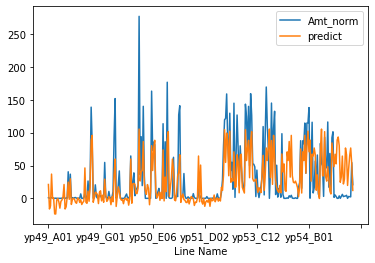

In [36]:
df3.plot(y = ['Amt_norm','predict'], x =  'Line Name')

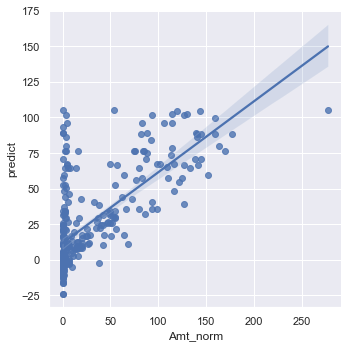

In [38]:
import seaborn as sns
from scipy.stats import pearsonr

#set seaborn plotting aesthetics as default
sns.set()

sns.set_context("paper", font_scale=6.0, rc={"lines.linewidth": 1.5})
sns.set(rc = {'figure.figsize':(30,30)})

sns.lmplot(data=df3, x="Amt_norm", y="predict",  palette="viridis")
None

### 4.2 Learning curve

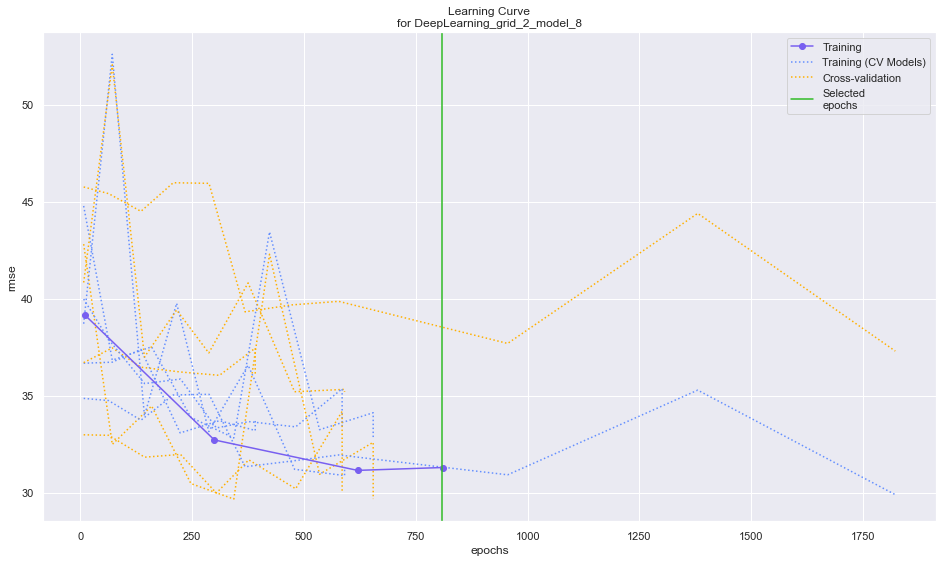

In [39]:

learning_curve = uploaded_model.learning_curve_plot()

#plt.title('Number of records by State')
None

In [40]:
as_data_frame_df_test

,Line Name,0,1,2,3,Amt_norm
0,yp49_A01,1,2,5,1,0.972701
1,yp49_A02,1,3,8,1,0.269401
2,yp49_A04,1,3,8,2,0.202699
3,yp49_A06,1,2,6,2,1.133272
4,yp49_A07,1,1,5,3,0.981070
...,...,...,...,...,...,...
288,yp54_F02,7,2,5,7,2.814061
289,yp54_F03,7,2,5,7,2.560352
290,yp54_F04,7,2,6,7,2.256023
291,yp54_F05,4,2,5,2,54.525222


### 4.3 Find predicted genotypes

In [41]:
import numpy as np

In [42]:
all_genotypes = pd.read_csv('ConStrain_on_google_colab/Data/processed/remaining_genotypes_after_first_iteration.csv',)
all_genotypes =all_genotypes[['0','1','2','3']]
all_genotypes

,0,1,2,3
0,1,1,5,1
1,1,1,5,2
2,1,1,5,4
3,1,1,5,5
4,1,1,5,7
...,...,...,...,...
1117,8,4,8,6
1118,8,4,8,7
1119,8,4,8,8
1120,8,4,8,9


In [43]:
all_genotypes_df = h2o.H2OFrame(pd.concat([all_genotypes], axis='columns'))
all_genotypes_df

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


0,1,2,3
1,1,5,1
1,1,5,2
1,1,5,4
1,1,5,5
1,1,5,7
1,1,5,8
1,1,5,9
1,1,6,1
1,1,6,2
1,1,6,3


In [44]:
#merge_ = pd.merge(new_input_for_ml,all_genotypes, on= ['0','1','2','3'])
#merge_
new_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/processed/input_for_ml_2nd_iteration.csv',  index_col=False)

input_fixed = new_input_for_ml[['0','1','2','3']]
input_fixed

,0,1,2,3
0,4,1,5,2
1,4,1,5,2
2,4,2,5,2
3,5,1,5,2
4,5,1,5,2
...,...,...,...,...
122,7,2,5,7
123,7,2,5,7
124,7,2,6,7
125,4,2,5,2


### 4.4 Getting rid of the genotypes we have already tested:

In [45]:
df_diff = all_genotypes[~all_genotypes.apply(tuple,1).isin(input_fixed.apply(tuple,1))]
#df_diff.to_csv('../data/processed/remaining_genotypes_after_first_iteration.csv')
df_diff

,0,1,2,3
0,1,1,5,1
1,1,1,5,2
2,1,1,5,4
3,1,1,5,5
4,1,1,5,7
...,...,...,...,...
1117,8,4,8,6
1118,8,4,8,7
1119,8,4,8,8
1120,8,4,8,9


In [46]:
# make the diff into a df 
all_genotypes_df = h2o.H2OFrame(pd.concat([df_diff], axis='columns'))
all_genotypes_df['0']= all_genotypes_df['0'].asfactor()
all_genotypes_df['1']= all_genotypes_df['1'].asfactor()
all_genotypes_df['2'] = all_genotypes_df['2'].asfactor()
all_genotypes_df['3'] = all_genotypes_df['3'].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [47]:
predicted = best_model.predict(all_genotypes_df)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [48]:
len(predicted)

1049

In [49]:
predicted_norm = predicted.as_data_frame()
predicted_norm.head()

,predict
0,-3.540472
1,-3.540472
2,-3.540472
3,-3.540472
4,-3.540472


In [50]:
# making predictions into a list
predicted_list = predicted_norm['predict'].values.tolist()

# Adding predictions to our dataframe
df_diff['predicted_norm_strict'] = predicted_list

# Sorting the dataframe
predicted_merged_sorted = df_diff.sort_values('predicted_norm_strict', ascending=False)
predicted_merged_sorted

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_43794/105107836.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['predicted_norm_strict'] = predicted_list


,0,1,2,3,predicted_norm_strict
754,6,2,6,10,114.730645
752,6,2,6,8,114.730645
748,6,2,6,2,114.730645
753,6,2,6,9,114.730645
570,5,1,5,10,111.321979
...,...,...,...,...,...
128,1,4,7,7,-17.319835
129,1,4,7,8,-17.319835
130,1,4,7,9,-17.319835
131,1,4,7,10,-17.319835


If we want the names on the genotypes we can do the following: 

In [51]:
g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]
promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

g8h_genotype = []
cpr_genotype = []

pg8h_genotype = []
pcpr_genotype = []

predicted_list = []
# adding index of genotypes to individual rows 
for index, row in predicted_merged_sorted.iterrows():
    g8h_genotype.append(g8h_list_of_index[int(row['0'])-1])
    cpr_genotype.append(cpr_list_of_index[int(row['3'])-1])
    pg8h_genotype.append(promoters[int(row['1'])-1])
    pcpr_genotype.append(promoters[int(row['2'])-1])
    predicted_list.append(row['predicted_norm_strict'])
    
    
list_of_lists = [g8h_genotype,pg8h_genotype,pcpr_genotype, cpr_genotype, predicted_list  ]

## 5. Top 20 predicted producers

In [52]:
df_with_genotypes = pd.DataFrame(list_of_lists )
df_with_genotypes = df_with_genotypes.T
df_with_genotypes.columns = ['G8H', 'pG8H', 'pCPR', 'CPR', 'Predicted_stric_production']
df_with_genotypes.head(20)


,G8H,pG8H,pCPR,CPR,Predicted_stric_production
0,Rsep,ENO2,TPI1,Cpo,114.730645
1,Rsep,ENO2,TPI1,Cac,114.730645
2,Rsep,ENO2,TPI1,Aan,114.730645
3,Rsep,ENO2,TPI1,Oeu,114.730645
4,Smus,CYC1,CCW12,Cpo,111.321979
5,Smus,CYC1,CCW12,Cac,111.321979
6,Smus,CYC1,CCW12,Ani,111.321979
7,Smus,CYC1,CCW12,Ahu,111.321979
8,Smus,CYC1,CCW12,Rse,111.321979
9,Smus,CYC1,CCW12,Ara,111.321979


In [57]:
df_with_genotypes.to_csv('ConStrain_on_google_colab/Data/AutoML/top20_ML_predicted_after_second_DBTL.csv', index=False)